In [1]:
# import modules 
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import numpy as np
import PIL
import io
import geoplot 
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# read ESPON LOGO 
im = plt.imread('Extra/espon-eu-logo-vector.png') # insert local ESPON logo.

In [3]:
# make the base map 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [4]:
fiji = world.query('name == "Fiji"')[['geometry']]

In [5]:
# Read shape file and associate data.

# read shape file 
covid = gpd.read_file('../../02_Data/01_GIS/02_Full file/Full shape/Full shape.shp')
# read shape file by ESPON
# shp0 = gpd.read_file('../../02_Data/01_GIS/01_ESPON Narrow MapKit NUTS2016/nuts-version2016-level0.shp')
# shp1 = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Data/ESPON MAPS/nuts-version2016-level1.shp')
# shp2 = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Data/ESPON MAPS/nuts-version2016-level2.shp')
# shp3 = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Data/ESPON MAPS/nuts-version2016-level3.shp')

## 1. Cases

### 1.1 New cases

In [6]:
## Read the data 
# Cases
cases = pd.read_excel('../../02_Data/02_Pandemic variables/01_Cases/EU_Cases_Weekly_Unstacked.xlsx')
cases.rename(columns = {"Unnamed: 0": 'nuts_id'}, inplace= True)
cases.index = cases.nuts_id
cases.drop('nuts_id', axis =1, inplace = True)

In [7]:
cases.dropna(thresh = len(cases) -200, axis = 1, inplace= True)

In [8]:
cases

,2020-03-15,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,2020-05-03,2020-05-10,2020-05-17,...,2021-10-10,2021-10-17,2021-10-24,2021-10-31,2021-11-07,2021-11-14,2021-11-21,2021-11-28,2021-12-05,2021-12-12
nuts_id,,,,,,,,,,,,,,,,,,,,,
AT111,0.0,5.0,10.0,3.0,4.0,3.0,0.0,1.0,0.0,0.0,...,27.0,23.0,56.0,87.0,203.0,294.0,277.0,271.0,146.0,64.0
AT112,5.0,27.0,51.0,27.0,10.0,9.0,5.0,3.0,2.0,3.0,...,160.0,165.0,267.0,455.0,773.0,911.0,1250.0,921.0,627.0,295.0
AT113,3.0,21.0,52.0,27.0,24.0,20.0,9.0,6.0,0.0,1.0,...,99.0,88.0,152.0,217.0,558.0,584.0,691.0,590.0,392.0,221.0
AT121,31.0,87.0,241.0,120.0,78.0,23.0,9.0,3.0,2.0,1.0,...,646.0,1105.0,1549.0,2298.0,2802.0,3676.0,3890.0,2677.0,1603.0,914.0
AT122,5.0,77.0,113.0,67.0,55.0,19.0,5.0,10.0,19.0,10.0,...,262.0,331.0,784.0,1173.0,1969.0,2858.0,3043.0,2291.0,1515.0,892.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EL411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.0,59.0,87.0,84.0,186.0,201.0,251.0,274.0,291.0,278.0
EL533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,10.0,48.0,94.0,128.0,103.0,85.0,103.0,39.0,42.0
EL541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,176.0,260.0,282.0,558.0,578.0,511.0,455.0,391.0,325.0


In [34]:
# turn dataframes into GeoDataFrames 
geo_cases = gpd.GeoDataFrame(pd.merge(cases, covid, left_on = cases.index, right_on = 'NUTS_ID').fillna(np.nan))
geo_cases = pd.concat([geo_cases,fiji])

In [35]:
geo_cases = pd.concat([geo_cases,fiji])

In [36]:
# change the CRS to Europe 
geo_cases = geo_cases.to_crs(epsg=3035) 
world = world.to_crs(epsg = 3035)
cities = cities.to_crs(epsg = 3035)

In [37]:
# Selecting only cities we want to see on the plot   
cities['x'] = cities['geometry'].x
cities['y'] = cities['geometry'].y
cities = cities[cities['x'] > 0.23e7]
cities = cities[cities['x'] < 0.67e7]
cities = cities[cities['y'] > 0.1e7]
cities = cities[cities['y'] < 0.545e7]
# Delete these cities from the plot 
cities = cities[~cities['name'].isin(['Beirut', 'Vatican City', 'Cairo', 'Jerusalem', 'Tripoli', 'Zagreb', 'Bratislava'])]

In [38]:
source="""Regional level: NUTS3 v2016 | Data version 2021.
Source: WHO EPISTAT, NPGEO, mscbs.gob.es.
santé-publique-France, statistichecoronavirus.it.
folkhalsomyndigheten, gov.scot, Korona.gov.sk.
data.gv.at, sso.dk, salute.gov.it."""

In [39]:
geo_cases.describe()

,2020-03-15,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,2020-05-03,2020-05-10,2020-05-17,...,2021-10-10,2021-10-17,2021-10-24,2021-10-31,2021-11-07,2021-11-14,2021-11-21,2021-11-28,2021-12-05,2021-12-12
count,1138.000000,1171.000000,1171.000000,1191.000000,1191.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,...,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1240.000000,1196.000000,1185.000000
mean,66.628295,126.523484,157.044406,158.774139,150.218304,102.203569,84.609084,63.656934,48.561233,43.287916,...,520.436508,613.964286,754.343651,862.088095,978.900794,1221.756349,1518.996825,1635.833065,1737.500836,1510.007595
std,522.306208,632.186142,465.352697,358.085303,328.232165,226.870812,185.684098,135.081348,110.198499,108.756328,...,1066.015047,1232.626723,1306.626566,1324.968516,1507.684863,1836.120489,2292.306385,2437.491538,2467.741654,2111.528601
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,10.000000,24.000000,24.000000,18.500000,10.000000,7.000000,4.000000,2.000000,2.000000,...,80.000000,86.000000,126.000000,172.000000,217.000000,293.750000,362.000000,408.000000,417.000000,405.000000
50%,9.000000,29.000000,66.000000,73.000000,60.000000,38.000000,26.000000,17.000000,12.000000,10.000000,...,172.000000,204.000000,301.500000,395.000000,498.000000,653.000000,806.500000,889.500000,925.000000,794.000000
75%,28.000000,82.000000,144.500000,170.000000,164.500000,116.000000,95.000000,61.000000,47.000000,41.000000,...,545.000000,668.250000,914.250000,1038.750000,1146.250000,1396.250000,1692.750000,1759.750000,1966.000000,1595.000000
max,15737.000000,17710.000000,11144.000000,6850.000000,5227.000000,3277.000000,2546.000000,1697.000000,1308.000000,1765.000000,...,20196.000000,21968.000000,21191.000000,17945.000000,17905.000000,22749.000000,28766.000000,29055.000000,25625.000000,17663.000000


In [40]:
geo_cases.max().max()

C:\Users\MHACHA~1\AppData\Local\Temp/ipykernel_4616/1633161215.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  geo_cases.max().max()


43040.0

In [ ]:
# Creating the bins 
bins = [-1, 0, 5, 100, 1000, 43040]
label = ['None', 'Less than 5', '5-100', '100-1000', 'More than 1000']
for col in geo_cases.iloc[:, :-2]:
    geo_cases[col] = pd.cut(geo_cases[col], bins = bins, labels= label)

In [ ]:
geo_cases

In [41]:
# set mamp general general aspect 

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['grid.color'] = "white"
plt.rcParams['axes.facecolor'] = '#f4f9fa'

In [42]:
## add the ESPON logo 
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

In [43]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 80

In [ ]:
# image_frames = []

# # create the maps 
for i in geo_cases.iloc[:,:-2]:
    fig, ax = plt.subplots(figsize = (12, 12))
    # Set the global map 
    world.plot(color = '#e5e3e6', ax = ax, edgecolor = 'w', linewidth = 0.8)
    # set out map 
    geo_cases.plot(column = geo_cases[i], ax =ax, cmap = 'RdPu', legend = True, alpha = .4,
              linewidth = 0.5, edgecolor = 'w', categorical = True, missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values"})   
    # add countries boundaries 
    world.query('iso_a3 != "IRL" and iso_a3 != "GBR" and iso_a3 != "ISL"').boundary.plot(color = 'w', linewidth = 1.4 , zorder  =1, ax =ax)
    # set the final limite
    plt.xlim(2.4e6, 6.6e6)
    plt.ylim(0.13e7, 0.545e7)
    # add capitals points 
    cities.plot(ax = ax, color = 'k', markersize = 1)
    for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.name):
        ax.annotate(label, xy=(x, y), xytext=(1, 2), textcoords="offset points", fontsize = 6.5)
    # Disable scientific representation 
    ax.ticklabel_format(useOffset=False, style='plain')

    # add the graphical-scale 
    scalebar = ScaleBar(0.66, width_fraction=None,
            location= "lower right", box_alpha = 0, length_fraction = 0.08,
                       height_fraction  = 0.003) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)

    # legend 
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0.24, 0)) 
    leg.get_frame().set_alpha(0)
    leg.set_title('NEW CASES')
    plt.title(f'  Weekly new confirmed COVID-19 cases: {pd.Timestamp(i).month_name()} - {i.year}', fontweight = 'light',
            fontsize= 14, loc = 'left', color = '#054ea2')
    # Set outside the figure color 
    fig.patch.set_facecolor('#fbfdfe')
    #  Set source 
    fig.text(0.92, .055, source, ha='right', fontsize = 8)
    # add ESPON's title 
    plt.text(x = 3.5e6, y = 1.4e6, s = u"\u00A9 ESPON EGTC, 2021", fontsize = 10)
    # add bleu lines 
    plt.vlines(x = 2.4e6, ymin = 1e6, ymax = 2e6, color = '#054ea2', linewidth = 10)
    plt.vlines(x = 2.4e6, ymin = 4.8e6, ymax = 6e6, color = '#054ea2', linewidth = 10)
    plt.vlines(x = 6.6e6, ymin = 1e6, ymax = 6e6, color = '#054ea2', linewidth = 10)

    plt.hlines(y = 0.13e7, xmin = 5.4e6, xmax = 6.6e6, color = '#054ea2', linewidth = 5)
    plt.hlines(y = 0.545e7, xmin = 2.4e6, xmax = 3.4e6, color = '#054ea2', linewidth = 5)
    # revome axis  
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # grid params 
    plt.tick_params(bottom = False, left = False)
    plt.grid(True, dash_capstyle = 'projecting')

    # add ESPON logo 
    newax = fig.add_axes([0.1, 0.003,0.14,0.18], anchor='NE', zorder=1)
    newax.imshow(im)
    newax.axis('off')
    plt.show()

    # img = ax.get_figure()
    # f = io.BytesIO()
    # img.savefig(f, format= 'png')
    # f.seek(0)
    # image_frames.append(PIL.Image.open(f))

In [ ]:
# create a GIF animation 
image_frames[0].save('Animated Maps/Dynamic COVID-19 new cases Map.gif', format = 'GIF', append_images = image_frames[1:],
                    save_all = True, duration = 800,
                     loop = 2)
f.close()

### 1.2 Cumulitave cases

In [85]:
cases_cumsum = np.cumsum(cases, axis =1)

In [86]:
# turn dataframes into GeoDataFrames 
cumsum_cases = gpd.GeoDataFrame(pd.merge(cases_cumsum, covid, left_on = cases.index, right_on = 'NUTS_ID').fillna(np.nan))
cumsum_cases = pd.concat([geo_cases,fiji])

In [87]:
# Creating the bins 
bins = [ 0, 100, 1000, 10000, 100000, 930000]
label = ['Less than 100', '100-1000', '1000-10000', '10000-100000', 'More than 100000']
for col in cumsum_cases.iloc[:, :-2]:
    cumsum_cases[col] = pd.cut(cumsum_cases[col], bins = bins, labels= label)

In [88]:
# change the CRS to Europe 
cumsum_cases = cumsum_cases.to_crs(epsg=3035) 

In [89]:
cases

,2020-03-15,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,2020-05-03,2020-05-10,2020-05-17,...,2021-10-10,2021-10-17,2021-10-24,2021-10-31,2021-11-07,2021-11-14,2021-11-21,2021-11-28,2021-12-05,2021-12-12
nuts_id,,,,,,,,,,,,,,,,,,,,,
AT111,0.0,5.0,10.0,3.0,4.0,3.0,0.0,1.0,0.0,0.0,...,27.0,23.0,56.0,87.0,203.0,294.0,277.0,271.0,146.0,64.0
AT112,5.0,27.0,51.0,27.0,10.0,9.0,5.0,3.0,2.0,3.0,...,160.0,165.0,267.0,455.0,773.0,911.0,1250.0,921.0,627.0,295.0
AT113,3.0,21.0,52.0,27.0,24.0,20.0,9.0,6.0,0.0,1.0,...,99.0,88.0,152.0,217.0,558.0,584.0,691.0,590.0,392.0,221.0
AT121,31.0,87.0,241.0,120.0,78.0,23.0,9.0,3.0,2.0,1.0,...,646.0,1105.0,1549.0,2298.0,2802.0,3676.0,3890.0,2677.0,1603.0,914.0
AT122,5.0,77.0,113.0,67.0,55.0,19.0,5.0,10.0,19.0,10.0,...,262.0,331.0,784.0,1173.0,1969.0,2858.0,3043.0,2291.0,1515.0,892.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EL411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.0,59.0,87.0,84.0,186.0,201.0,251.0,274.0,291.0,278.0
EL533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,10.0,48.0,94.0,128.0,103.0,85.0,103.0,39.0,42.0
EL541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,176.0,260.0,282.0,558.0,578.0,511.0,455.0,391.0,325.0


In [91]:
cumsum_cases

,2020-03-15 00:00:00,2020-03-22 00:00:00,2020-03-29 00:00:00,2020-04-05 00:00:00,2020-04-12 00:00:00,2020-04-19 00:00:00,2020-04-26 00:00:00,2020-05-03 00:00:00,2020-05-10 00:00:00,2020-05-17 00:00:00,...,2021-10-24 00:00:00,2021-10-31 00:00:00,2021-11-07 00:00:00,2021-11-14 00:00:00,2021-11-21 00:00:00,2021-11-28 00:00:00,2021-12-05 00:00:00,2021-12-12 00:00:00,NUTS_ID,geometry
0,NaN,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,NaN,Less than 100,NaN,NaN,...,Less than 100,Less than 100,100-1000,100-1000,100-1000,100-1000,100-1000,Less than 100,AT111,"POLYGON ((4821838.742 2726166.304, 4809143.714..."
1,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,...,100-1000,100-1000,100-1000,100-1000,1000-10000,100-1000,100-1000,100-1000,AT112,"POLYGON ((4854633.443 2791782.864, 4851092.605..."
2,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,NaN,Less than 100,...,100-1000,100-1000,100-1000,100-1000,100-1000,100-1000,100-1000,100-1000,AT113,"POLYGON ((4806751.304 2714374.758, 4810965.710..."
3,Less than 100,Less than 100,100-1000,100-1000,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,...,1000-10000,1000-10000,1000-10000,1000-10000,1000-10000,1000-10000,1000-10000,100-1000,AT121,"POLYGON ((4729365.117 2815976.523, 4729868.614..."
4,Less than 100,Less than 100,100-1000,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,...,100-1000,1000-10000,1000-10000,1000-10000,1000-10000,1000-10000,1000-10000,100-1000,AT122,"POLYGON ((4798615.884 2772722.270, 4792731.113..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100-1000,100-1000,100-1000,100-1000,100-1000,100-1000,100-1000,100-1000,EL542,"POLYGON ((5212814.992 1916169.236, 5220985.354..."
1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,Less than 100,EL543,"POLYGON ((5259658.107 1963657.167, 5258265.927..."
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((7696097.606 14817308.230, 7730..."
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((7696097.606 14817308.230, 7730..."


C:\Users\mhachaichi\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


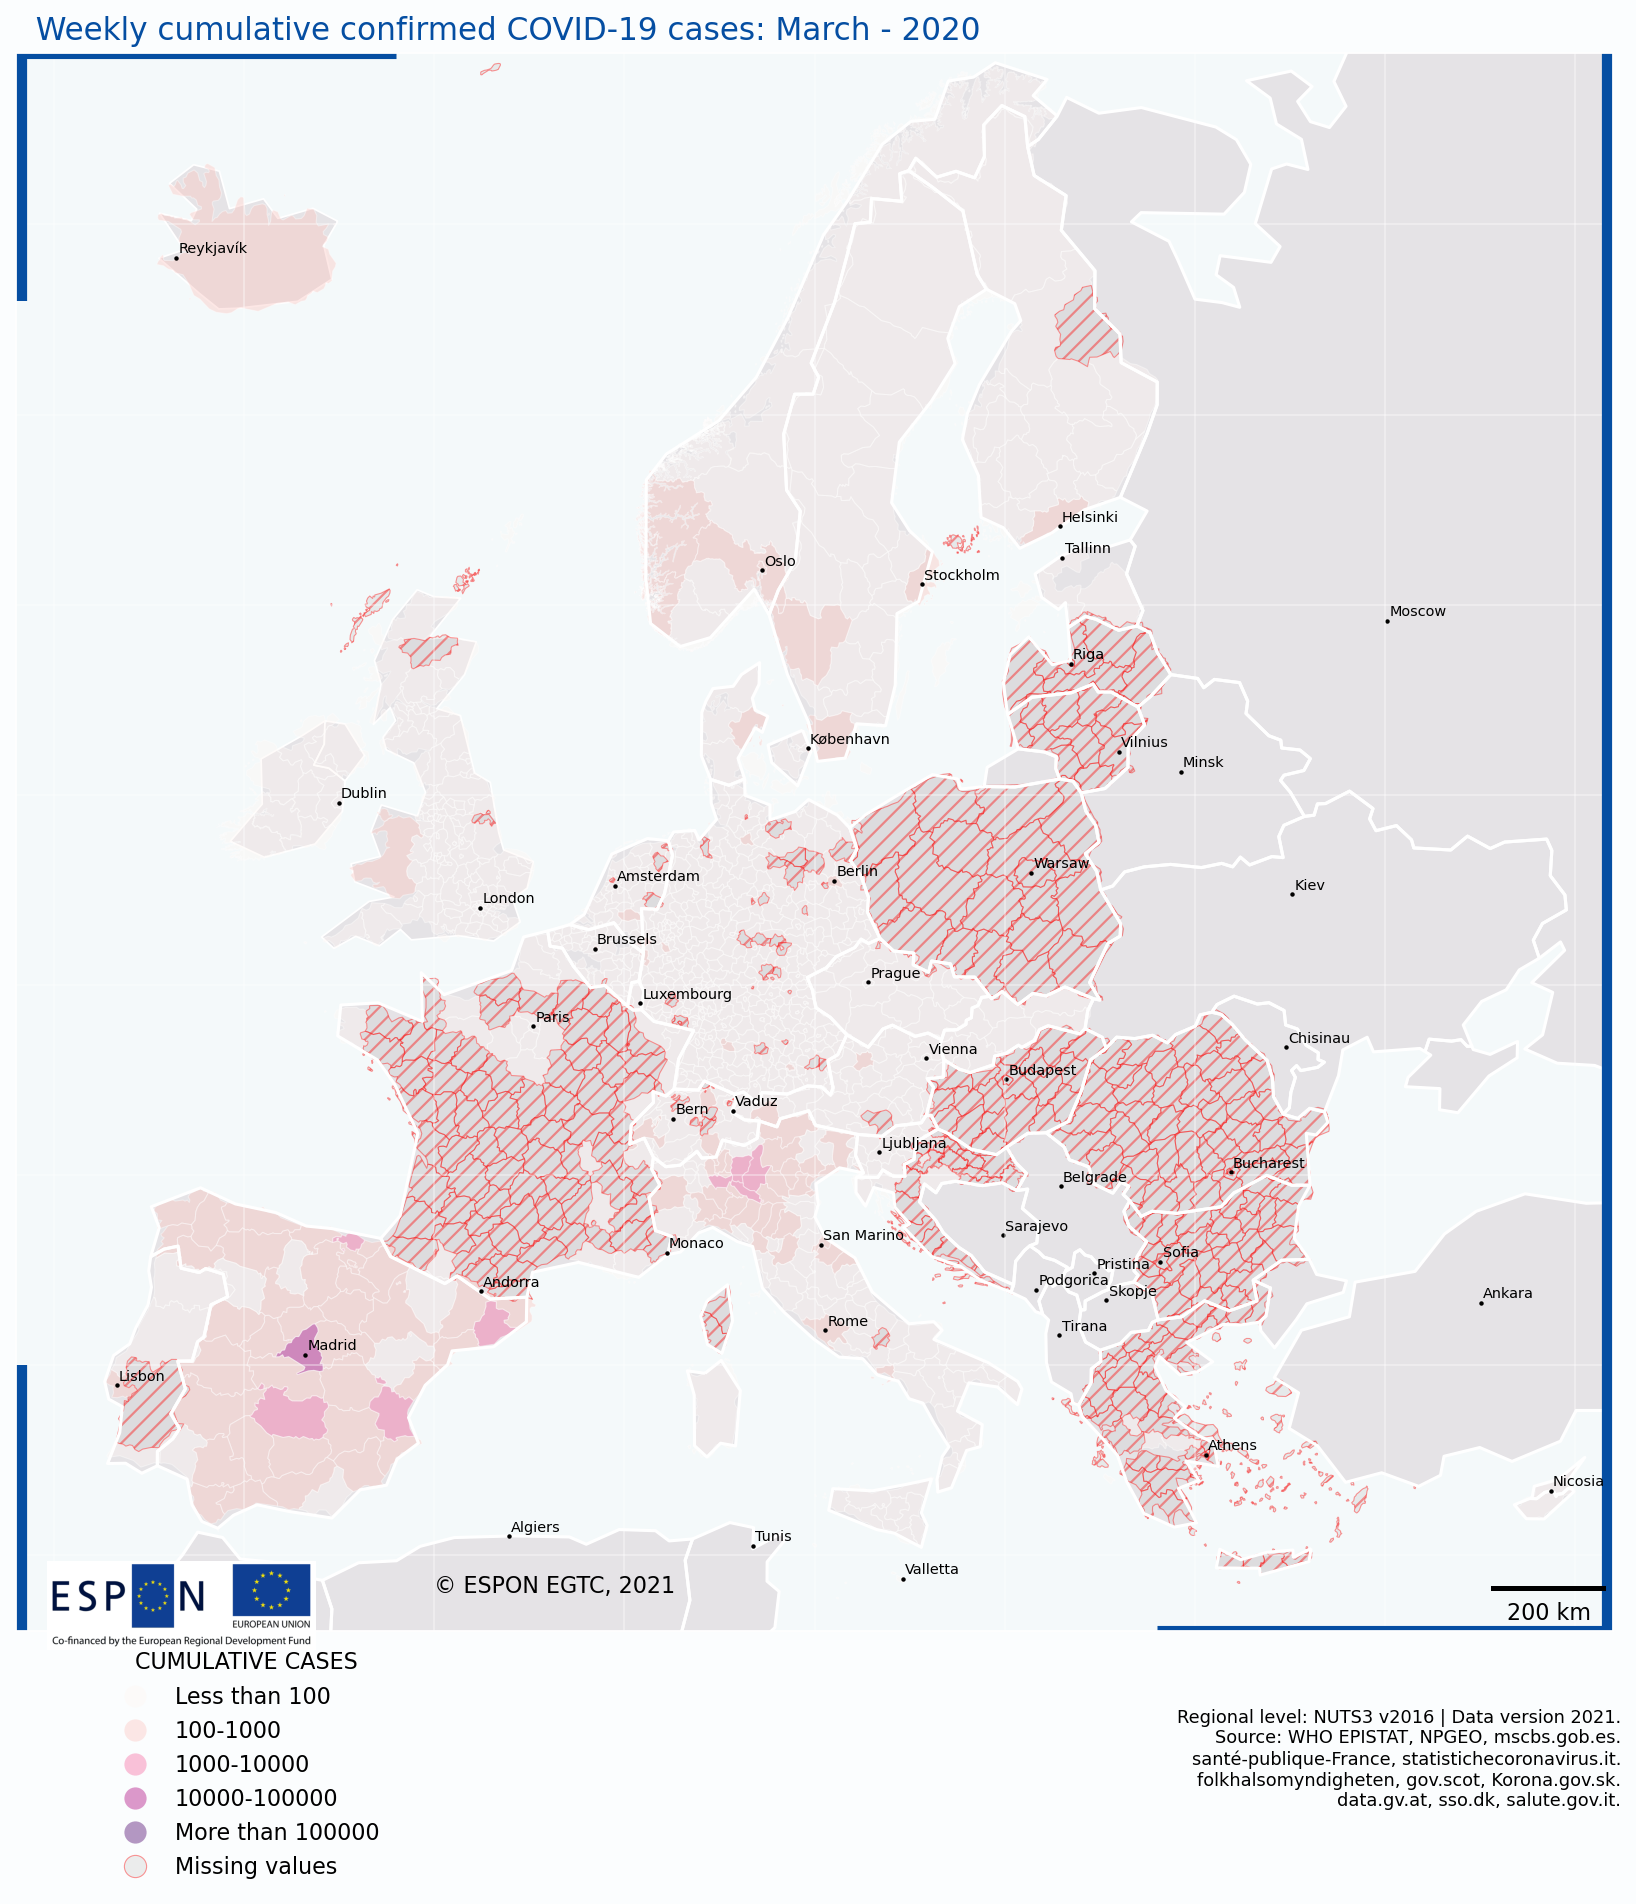

In [ ]:
# image_frames = []

# # create the maps 
for i in cumsum_cases.iloc[:,:-2]:
    fig, ax = plt.subplots(figsize = (12, 12))
    # Set the global map 
    world.plot(color = '#e5e3e6', ax = ax, edgecolor = 'w', linewidth = 0.8)
    # set out map 
    cumsum_cases.plot(column = cumsum_cases[i], ax =ax, cmap = 'RdPu', legend = True, alpha = .4,
              linewidth = 0.5, edgecolor = 'w', categorical = True, missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values"})   
    # add countries boundaries 
    world.query('iso_a3 != "IRL" and iso_a3 != "GBR" and iso_a3 != "ISL"').boundary.plot(color = 'w', linewidth = 1.4 , zorder  =1, ax =ax)
    # set the final limite
    plt.xlim(2.4e6, 6.6e6)
    plt.ylim(0.13e7, 0.545e7)
    # add capitals points 
    cities.plot(ax = ax, color = 'k', markersize = 1)
    for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.name):
        ax.annotate(label, xy=(x, y), xytext=(1, 2), textcoords="offset points", fontsize = 6.5)
    # Disable scientific representation 
    ax.ticklabel_format(useOffset=False, style='plain')

    # add the graphical-scale 
    scalebar = ScaleBar(0.66, width_fraction=None,
            location= "lower right", box_alpha = 0, length_fraction = 0.08,
                       height_fraction  = 0.003) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)

    # legend 
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0.24, 0)) 
    leg.get_frame().set_alpha(0)
    leg.set_title('CUMULATIVE CASES')
    plt.title(f'  Weekly cumulative confirmed COVID-19 cases: {pd.Timestamp(i).month_name()} - {i.year}', fontweight = 'light',
            fontsize= 14, loc = 'left', color = '#054ea2')
    # Set outside the figure color 
    fig.patch.set_facecolor('#fbfdfe')
    #  Set source 
    fig.text(0.92, .055, source, ha='right', fontsize = 8)
    # add ESPON's title 
    plt.text(x = 3.5e6, y = 1.4e6, s = u"\u00A9 ESPON EGTC, 2021", fontsize = 10)
    # add bleu lines 
    plt.vlines(x = 2.4e6, ymin = 1e6, ymax = 2e6, color = '#054ea2', linewidth = 10)
    plt.vlines(x = 2.4e6, ymin = 4.8e6, ymax = 6e6, color = '#054ea2', linewidth = 10)
    plt.vlines(x = 6.6e6, ymin = 1e6, ymax = 6e6, color = '#054ea2', linewidth = 10)

    plt.hlines(y = 0.13e7, xmin = 5.4e6, xmax = 6.6e6, color = '#054ea2', linewidth = 5)
    plt.hlines(y = 0.545e7, xmin = 2.4e6, xmax = 3.4e6, color = '#054ea2', linewidth = 5)
    # revome axis  
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # grid params 
    plt.tick_params(bottom = False, left = False)
    plt.grid(True, dash_capstyle = 'projecting')

    # add ESPON logo 
    newax = fig.add_axes([0.1, 0.003,0.14,0.18], anchor='NE', zorder=1)
    newax.imshow(im)
    newax.axis('off')
    plt.show()

    # img = ax.get_figure()
    # f = io.BytesIO()
    # img.savefig(f, format= 'png')
    # f.seek(0)
    # image_frames.append(PIL.Image.open(f))

In [ ]:
# create a GIF animation 
image_frames[0].save('Animated Maps/Dynamic COVID-19 cumulative cases Map.gif', format = 'GIF', append_images = image_frames[1:],
                    save_all = True, duration = 800,
                     loop = 2)
f.close()

## 2. Deaths

## 3. Exc. Mortality 